In [24]:
import pandas as pd
import ast
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('Hotel_Reviews.csv') #read the csv file

In [3]:
# This is the basic data cleaning process. This should be added in all the models
# This cell is a bit slow to run, so it is intended to be run only once

# This part drops the columns that are not needed in the model
data.drop('Hotel_Address',axis=1,inplace=True)  # Drop the column 'Hotel_Address' due to lack of relevance
data.drop('Review_Date',axis=1,inplace=True)    # Drop the column 'Review_Date' due to lack of complete data
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  # Drop the column 'Additional_Number_of_Scoring' due to not knowing what the numbers mean
data.drop('lat',axis=1,inplace=True)    # Drop the column 'lat' due to lack of relevance
data.drop('lng',axis=1,inplace=True)    # Drop the column 'lng' due to lack of relevance
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)    # Drop the column 'Total_Number_of_Reviews' due to the number seams to be incorrect


# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns
data.drop('Tag_5',axis=1,inplace=True)  # Drop the column 'Tag_5' as it is empty.

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
hotel_names = data['Hotel_Name'] # Create a new dataframe with the hotel names
data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' as it is not needed in the model

In [4]:
#This cell is designed specifically for the xgboost regressor model, but can be used in other models as well

xgb_data = data.copy() # Create a copy of the dataframe data
xgb_data.drop('Reviewer_Nationality',axis=1,inplace=True) # Drop the column 'Revierer_Nationality' as it will give to many columns when one hot encoded
xgb_data.drop('Negative_Review',axis=1,inplace=True) # Drop the column 'Negative_Review' as it is not a numeric value
xgb_data.drop('Positive_Review',axis=1,inplace=True) # Drop the column 'Positive_Review' as it is not a numeric value

# One hot encode only the necessary columns
xgb_data = pd.get_dummies(xgb_data, columns=['Tag_0', 'Tag_1', 'Tag_2', 'Tag_4'], dtype=int)

# Turn the 'Reviewer_Score' column into a scale from 0-100 instead of 0-10
xgb_data['Reviewer_Score'] = xgb_data['Reviewer_Score'] * 10
xgb_data['Reviewer_Score']=xgb_data['Reviewer_Score'].astype(int) # Convert the 'Reviewer_Score' column to int

In [ ]:
# The next part of the code splits the data into training and testing data. 
# The target can of course be changed to a bin type if needed.
x = xgb_data.drop('Reviewer_Score',axis=1) # Define the features
y = xgb_data['Reviewer_Score'] # Define the target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=69) # Split the data into training and testing data test_size is big due to memory issues when training the model

In [ ]:
xgb_model = xgb.XGBRegressor(tree_method='hist',max_depth=3,n_estimators=50,gamma=0.2,subsample=0.8,colsample_bytree=0.8, learning_rate=0.05) # Create the xgboost model. The parameters are designed to limit the memory usage
xgb_model.fit(x_train, y_train) # Fit the model to the training data

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
guess=xgb_model.predict(x_test) # Make a guess on the testing data

In [ ]:
mse=mean_squared_error(y_test,guess) # Calculate the mean squared error
print(mse)

160.60496788155643


In [19]:
mae=mean_absolute_error(y_test,guess) # Calculate the mean absolute error
print(mae)

9.693391010585954


In [20]:
r2=r2_score(y_test,guess) # Calculate the r2 score
print(r2)

0.3999471664428711


In [21]:
mape=mean_absolute_percentage_error(y_test,guess) # Calculate the mean absolute percentage error
print(mape)

0.1433266391497184


In [23]:
medianae=median_absolute_error(y_test,guess) # Calculate the median absolute error
print(medianae)

7.826377868652344


<Axes: xlabel='Reviewer_Score'>

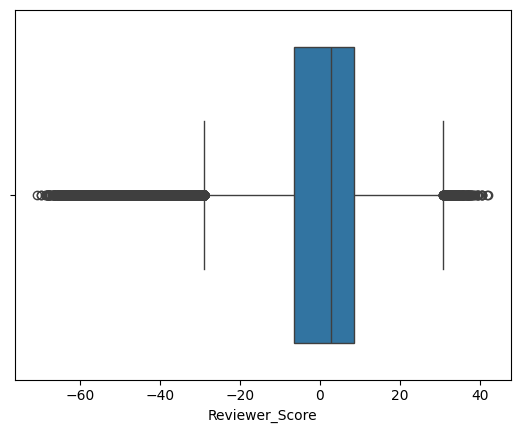

In [26]:
sns.boxplot(x=y_test-guess) # Create a boxplot of the data